In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import get_cmap
from time import time

from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation, \
    SpectralClustering, MeanShift
from sklearn import metrics

import dill as pickle

tsne = pickle.load(open("tSNE", "rb"))
df_tsne_2d = tsne.embedding_
drawData = pickle.load(open("drawData", "rb"))

In [14]:
complete_preprocessed = pd.read_pickle("preprocessed")
complete_preprocessed.head()
complete = pd.read_pickle("complete")

In [15]:
ipca = IncrementalPCA(n_components=10, batch_size=30)
df_pca = ipca.fit_transform(complete_preprocessed)
ipca.explained_variance_ratio_.cumsum()


array([ 0.15970458,  0.24622809,  0.32275451,  0.39738982,  0.46496188,
        0.51779215,  0.55724697,  0.59144712,  0.62383674,  0.65274646])

ça veut dire que les variances éxpliquées par des composantes principales sont réparties de façon relativement équilibrée et qu'on aura mal à représenter les données par seulement quelques composantes. On ne peut donc pas utiliser des méthodes de réduction de dimensions courante.

In [30]:
df_sampled = complete_preprocessed.sample(2000)

In [43]:
echantillon2 = np.random.choice(complete_preprocessed.shape[0], 1000, replace=False) 
# For plotting

/usr/bin/usr/bin/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


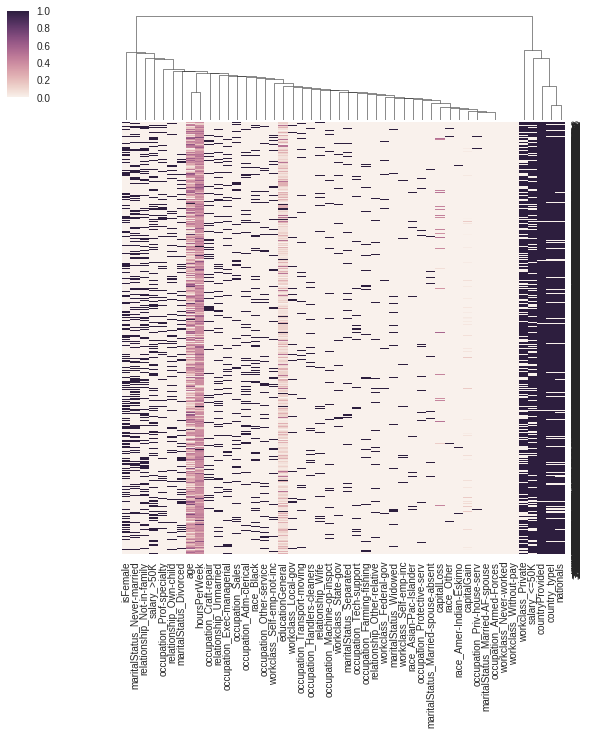

In [20]:
plt.figure()
sns.clustermap(df_sampled, row_cluster = True)
plt.show()

In [17]:

kmeans = KMeans(n_clusters = 5)
kmeans.fit_transform(complete_preprocessed)

array([[ 2.20562964,  2.49607691,  1.98743022,  1.44371001,  2.10193886],
       [ 1.68000443,  1.84713227,  1.08443439,  1.78071208,  1.68117915],
       [ 2.46730663,  1.5843568 ,  2.11555636,  2.56544873,  2.48470643],
       ..., 
       [ 1.43726428,  2.44677795,  2.0462457 ,  2.27213062,  2.13104565],
       [ 2.00581413,  2.30992348,  1.79692693,  1.0614474 ,  1.87099925],
       [ 2.43888493,  1.89101731,  2.53016902,  2.7990371 ,  2.67693538]])

5


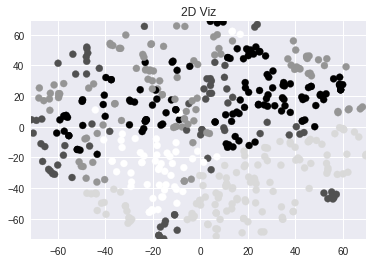

In [18]:
kmeans.labels_[:50]

echantillon = np.random.choice(complete_preprocessed.shape[0], 500, replace=False)
drawData(df_tsne_2d[echantillon, :], pd.Series(kmeans.labels_[echantillon]))

+Spectral clustering, Gaussian mixtures, DBscan, isolation forest, EMM

In [20]:
db = DBSCAN(eps=0.3, min_samples=10).fit(df_sampled)
labels_true = df_sampled["salary_>50K"]
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(df_sampled, labels))

Estimated number of clusters: 10
Homogeneity: 0.213
Completeness: 0.136
V-measure: 0.166
Adjusted Rand Index: 0.078
Adjusted Mutual Information: 0.131
Silhouette Coefficient: -0.088


In [38]:
df_sampled[class_member_mask & core_samples_mask]

,age,capitalGain,capitalLoss,hoursPerWeek,countryProvided,country_typeI,nationals,educationGeneral,workclass_Federal-gov,workclass_Local-gov,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,isFemale
13992,0.369863,0.076881,0.0,0.500000,1,1,1,0.2500,0,0,...,0,0,0,0,0,0,0,0,0,0
35411,0.561644,0.051781,0.0,0.602041,1,1,1,0.1250,0,0,...,0,0,0,0,0,0,0,0,0,0
42196,0.219178,0.150242,0.0,0.500000,1,1,1,0.2500,0,0,...,0,0,0,0,0,0,0,0,0,0
46827,0.410959,0.000000,0.0,0.397959,1,1,1,0.1250,0,0,...,0,0,0,0,0,0,0,0,0,0
35356,0.397260,0.000000,0.0,0.397959,1,1,1,0.0625,0,0,...,0,0,0,0,0,0,0,0,0,0
32151,0.260274,0.000000,0.0,0.602041,1,1,1,0.1250,0,0,...,0,0,0,0,0,0,0,0,0,0
18684,0.547945,0.000000,0.0,0.397959,1,1,1,0.2500,0,0,...,0,0,0,0,0,0,0,0,0,0
27392,0.150685,0.000000,0.0,0.397959,1,1,1,0.2500,0,0,...,0,0,0,0,0,0,0,0,0,0
28827,0.301370,0.000000,0.0,0.448980,1,1,1,0.2500,0,0,...,0,0,0,0,0,0,0,0,0,0
31213,0.315068,0.000000,0.0,0.653061,1,1,1,0.2500,0,0,...,0,0,0,0,0,0,0,0,0,0


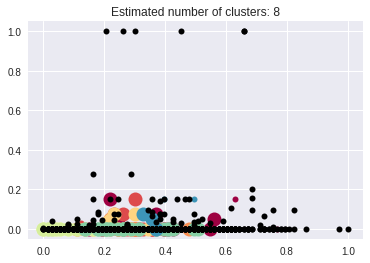

In [39]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = df_sampled[class_member_mask & core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = df_sampled[class_member_mask & ~core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

8


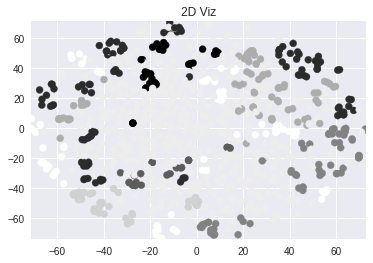

In [56]:
spc = SpectralClustering()
spc.fit(complete_preprocessed.loc[echantillon2, :])

drawData(df_tsne_2d[echantillon2, :], pd.Series(spc.labels_))


104


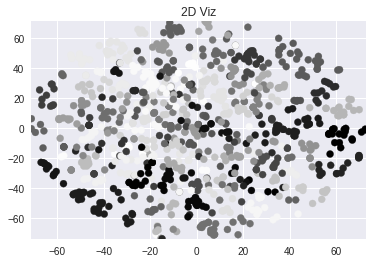

In [47]:
ap = AffinityPropagation()
ap.fit(complete_preprocessed.loc[echantillon2, :])

drawData(df_tsne_2d[echantillon2, :], pd.Series(ap.labels_))

1


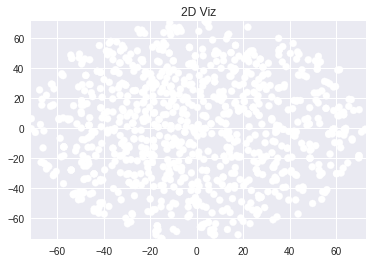

In [48]:
ms = MeanShift()
ms.fit(complete_preprocessed.loc[echantillon2, :])

drawData(df_tsne_2d[echantillon2, :], pd.Series(ms.labels_))

ward : 0.05s
10
average : 0.04s
10
complete : 0.04s
10


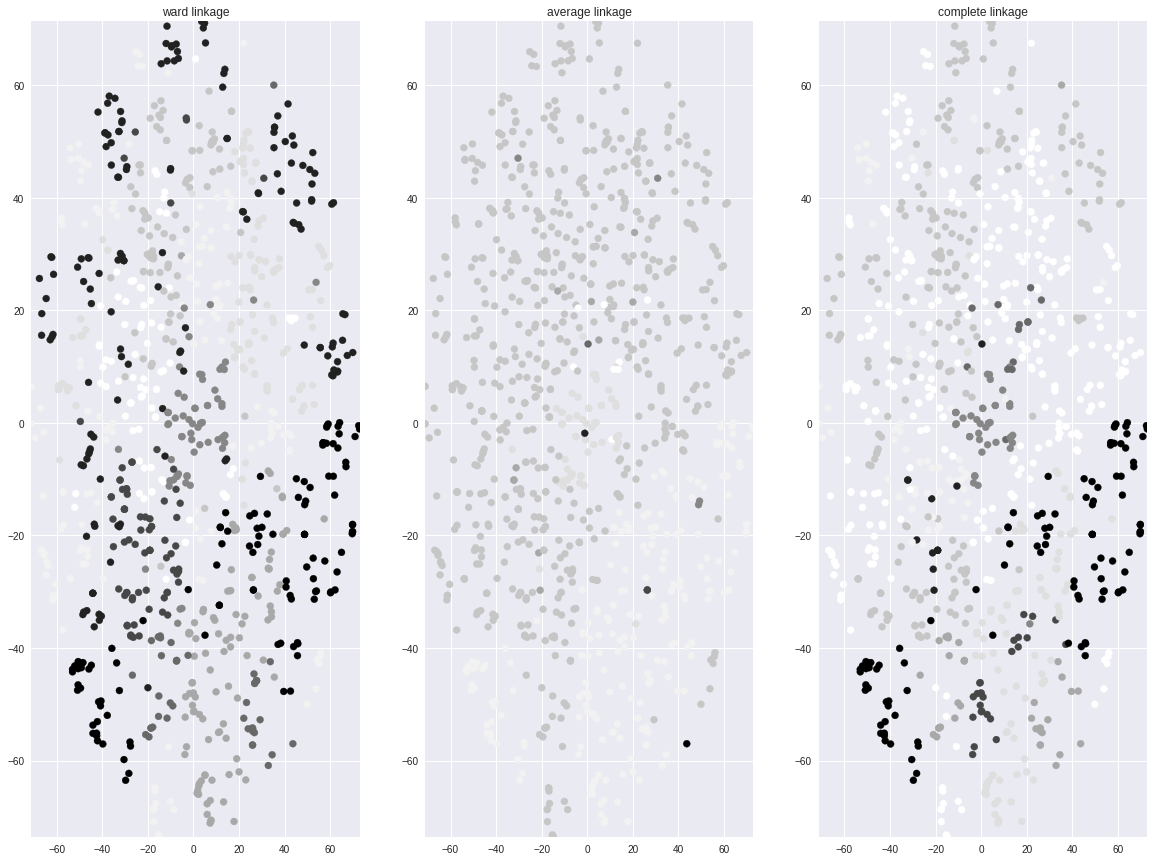

In [54]:
plt.figure(figsize=(20, 15))

for i, linkage in enumerate(['ward', 'average', 'complete']):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=10)
    t0 = time()
    clustering.fit(complete_preprocessed.loc[echantillon2, :])
    print("%s : %.2fs" % (linkage, time() - t0))

    plt.subplot(1, 3, i+1)
    drawData(df_tsne_2d[echantillon2, :], pd.Series(clustering.labels_), 
             titre = "%s linkage" % linkage)


plt.show()
